In [3]:
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import os
import datetime

# Setup Selenium WebDriver
driver = webdriver.Chrome()

# Define the list of URLs and the page limit per URL
urls = [
    "https://www.tokopedia.com/search?st=&q=hoodie&srp_component_id=02.01.00.00&srp_page_id=&srp_page_title=&navsource=",
    "https://www.tokopedia.com/search?st=&q=keyboard&srp_component_id=02.01.00.00&srp_page_id=&srp_page_title=&navsource=",
    "https://www.tokopedia.com/search?st=&q=mac&srp_component_id=02.01.00.00&srp_page_id=&srp_page_title=&navsource=",
    "https://www.tokopedia.com/search?st=&q=keycaps&srp_component_id=02.01.00.00&srp_page_id=&srp_page_title=&navsource=",
    "https://www.tokopedia.com/search?st=&q=laptop%20gaming&srp_component_id=02.01.00.00&srp_page_id=&srp_page_title=&navsource=",
    "https://www.tokopedia.com/search?st=&q=switch&srp_component_id=02.01.00.00&srp_page_id=&srp_page_title=&navsource=",
    "https://www.tokopedia.com/search?st=&q=ps5&srp_component_id=02.01.00.00&srp_page_id=&srp_page_title=&navsource=",
    "https://www.tokopedia.com/search?st=&q=iphone&srp_component_id=02.01.00.00&srp_page_id=&srp_page_title=&navsource="
]
pages_per_url = 150
data_limit = 15000
output_file = 'tokopedia_data.csv'
timeout_minutes = 5  # Set the timeout period (5 minutes)

# Helper function to handle missing elements
def get_text_or_na(element):
    return element.get_text().strip() if element else "N/A"


total_pages = pages_per_url * len(urls)

# Function to check if more than 5 minutes have passed since last update
def has_timeout_exceeded(last_update_time):
    return (datetime.datetime.now() - last_update_time).total_seconds() > timeout_minutes * 60

# Loop through each URL
for base_url in urls:
    last_update_time = datetime.datetime.now()  # Initialize the last update time
    for current_page in range(1, pages_per_url + 1):
        # Construct the full URL for the current page
        url = f"{base_url}&page={current_page}"
        driver.get(url)
        
        # Wait for the page to load
        time.sleep(5)

        # Scroll down multiple times to load all products in smaller increments
        for _ in range(10):
            driver.execute_script("window.scrollBy(0, 500);")
            time.sleep(3)

        # Extract page content (HTML)
        page_html = driver.page_source
        soup = BeautifulSoup(page_html, "html.parser")

        # Find all product boxes on the current page
        product_boxes = soup.find_all('div', {"class": "css-5wh65g"})

        # Create lists to store data for this page
        product_names = []
        product_prices = []
        sellers = []
        store_locations = []
        sold_quantities = []
        ratings = []
        # reviews = []  # New list for reviews

        # for i, product in enumerate(product_boxes):
        #     detail_page = driver.find_elements(By.CLASS_NAME, "css-5wh65g")[i]
        #     detail_page.click()
        #     time.sleep(3)

        #     # Scroll down multiple times to ensure content is loaded
        #     for _ in range(10):
        #         driver.execute_script("window.scrollBy(0, 1000);")
        #         time.sleep(2)

        #     # Locate the review section
        #     try:
        #         review_section = driver.find_element(By.CSS_SELECTOR, 'article.css-72zbc4')
        #         review_class = review_section.find_element(By.CSS_SELECTOR, 'div.css-1k41fl7')
        #         review_deeper = review_class.find_element(By.CSS_SELECTOR, 'p.css-ybiclm-unf-heading.e1qvo2ff8')
        
        #         # Attempt to click the 'Load More' button if it exists
        #         try:
        #             load_more_button = review_deeper.find_element(By.CSS_SELECTOR, 'button.css-89c2tx')
        #             load_more_button.click()
        #             time.sleep(3)
        #             # Scroll to load more reviews
        #             driver.execute_script("window.scrollBy(0, 1000);")
        #             time.sleep(2)
        #         except:
        #             print("No 'Load More' button found, proceeding with available reviews.")

        #         # Find the review element
        #         review_element = review_deeper.find_element(By.CSS_SELECTOR, 'span.lblItemUlasan')
        #         reviews.append(get_text_or_na(review_element))
        #     except:
        #         reviews.append("N/A")  # Handle missing review case
    
    # # Navigate back to the product list page
    #         driver.back()
    #         time.sleep(3)
            
        for product in product_boxes:
            name = product.find('span', {"class": "OWkG6oHwAppMn1hIBsC3pQ=="})
            price = product.find('div', {"class": "_8cR53N0JqdRc+mQCckhS0g=="})
            seller = product.find('span', {"class": "X6c-fdwuofj6zGvLKVUaNQ== -9tiTbQgmU1vCjykywQqvA== flip"})
            location = product.find('span', {"class": "-9tiTbQgmU1vCjykywQqvA== flip"})
            sold = product.find('span', {"class": "eLOomHl6J3IWAcdRU8M08A=="})
            rating = product.find('span', {"class": "nBBbPk9MrELbIUbobepKbQ=="})

            # Append the extracted data using the helper function
            product_names.append(get_text_or_na(name))
            product_prices.append(get_text_or_na(price))
            sellers.append(get_text_or_na(seller))
            store_locations.append(get_text_or_na(location))
            sold_quantities.append(get_text_or_na(sold))
            ratings.append(get_text_or_na(rating))

        # Create a DataFrame with the current page's data
        page_data = pd.DataFrame({
            'Product': product_names,
            'Price': product_prices,
            'Seller': sellers,
            'Location': store_locations,
            'Sold': sold_quantities,
            'Rating': ratings # Add the reviews to the DataFrame
        })

        # Drop rows where all values are "N/A"
        page_data.replace("N/A", pd.NA, inplace=True)
        page_data.dropna(how='all', inplace=True)

        # Check if new data was found
        if not page_data.empty:  # Only save if the DataFrame is not empty
            # Save the data to a CSV file, append if the file already exists
            page_data.to_csv(output_file, mode='a', header=not os.path.exists(output_file), index=False)
            last_update_time = datetime.datetime.now()  # Reset the timer
        # Check if the data limit has been reached
        if len(product_names) >= data_limit:
            print(f"Data limit reached: {len(product_names)} products scraped.")
            break

        # Check if timeout exceeded (if no new data in the last 5 minutes)
        if has_timeout_exceeded(last_update_time):
            print(f"No data update for {timeout_minutes} minutes. Moving to the next URL.")
            break  # Break the page loop and move to the next URL

# Close the WebDriver after scraping
driver.quit()

print(f"Data has been progressively saved to {output_file}")


No data update for 5 minutes. Moving to the next URL.
No data update for 5 minutes. Moving to the next URL.


WebDriverException: Message: disconnected: not connected to DevTools
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=129.0.6668.90)
Stacktrace:
0   chromedriver                        0x0000000102900248 cxxbridge1$str$ptr + 1907280
1   chromedriver                        0x00000001028f8730 cxxbridge1$str$ptr + 1875768
2   chromedriver                        0x000000010250c260 cxxbridge1$string$len + 89488
3   chromedriver                        0x00000001024f60fc core::str::slice_error_fail::hbaf5d05fe3921cd2 + 63636
4   chromedriver                        0x00000001024f603c core::str::slice_error_fail::hbaf5d05fe3921cd2 + 63444
5   chromedriver                        0x000000010258a234 cxxbridge1$string$len + 605540
6   chromedriver                        0x000000010254512c cxxbridge1$string$len + 322652
7   chromedriver                        0x0000000102545d7c cxxbridge1$string$len + 325804
8   chromedriver                        0x00000001028c84d8 cxxbridge1$str$ptr + 1678560
9   chromedriver                        0x00000001028cce40 cxxbridge1$str$ptr + 1697352
10  chromedriver                        0x00000001028ad5ec cxxbridge1$str$ptr + 1568244
11  chromedriver                        0x00000001028cd710 cxxbridge1$str$ptr + 1699608
12  chromedriver                        0x000000010289eb90 cxxbridge1$str$ptr + 1508248
13  chromedriver                        0x00000001028e9828 cxxbridge1$str$ptr + 1814576
14  chromedriver                        0x00000001028e9980 cxxbridge1$str$ptr + 1814920
15  chromedriver                        0x00000001028f83d0 cxxbridge1$str$ptr + 1874904
16  libsystem_pthread.dylib             0x0000000184496f94 _pthread_start + 136
17  libsystem_pthread.dylib             0x0000000184491d34 thread_start + 8


In [35]:
df = pd.read_csv('tokopedia_data.csv')
def categorize_product(product_name):
    if 'sepatu' in product_name.lower():
        return 'sepatu'
    elif 'ps5' in product_name.lower():
        return 'ps5'
    elif 'switch' in product_name.lower():
        return 'switch'
    else:
        return 'other'  # Default category for unrecognized items

# Apply the function to create a new 'category' column
df['category'] = df['Product'].apply(categorize_product)

# Display the updated DataFrame
# print(df.head(50))
print(df.tail(100))

                                                 Product         Price  \
10528  HYDRA+ LONE Wall Charger 12W PD QC 3.0 Support...      Rp45.000   
10529  KUULAA KL-X57 MFI USB C to iPhone Lightning So...      Rp99.000   
10530  UGREEN Kabel iPhone MFi USB C To Lightning Nyl...     Rp165.000   
10531  CHARGER ADAPTOR IPHONE 20W TYPE C ORIGINAL FAS...      Rp80.000   
10532  Adapter Audio Converter iPhone . Adaptor Light...      Rp35.000   
...                                                  ...           ...   
10623  IMEI RESMI Apple iPhone 15 Plus 128GB 256GB 51...  Rp14.499.000   
10624             iphone 11 pro 256GB second imei lancar   Rp5.800.000   
10625  iPhone 11 Second Original 256GB/128GB/64GB Sec...   Rp4.180.000   
10626  APPLE IPHONE 13 PRO 256GB ORIGINAL MULUS GOOD ...  Rp10.785.000   
10627                                    iphone 4s bekas     Rp230.000   

                                 Seller        Location          Sold  Rating  \
10528             HYDRA+ Offic

In [36]:
df.shape

(10628, 7)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10628 entries, 0 to 10627
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Product   10628 non-null  object 
 1   Price     10628 non-null  object 
 2   Seller    10628 non-null  object 
 3   Location  10628 non-null  object 
 4   Sold      7715 non-null   object 
 5   Rating    7241 non-null   float64
 6   category  10628 non-null  object 
dtypes: float64(1), object(6)
memory usage: 581.3+ KB


In [38]:
# Remove the 'Rp' and convert to float
df['Price'] = df['Price'].str.replace('Rp', '', regex=False)  # Remove 'Rp'
df['Price'] = df['Price'].str.replace('.', '', regex=False)  # Remove dots used as thousand separators
df['Price'] = df['Price'].astype(float)  # Convert to float

# Verify the changes
df.info()

# Check the first few rows to ensure the format is correct
print(df['Price'].head())


AttributeError: Can only use .str accessor with string values!

In [39]:

# Function to categorize products (case-insensitive)
def categorize_product(product_name):
    product_name = product_name.lower()
    if 'sepatu' in product_name:
        return 'sepatu'
    elif 'ps5' in product_name:
        return 'ps5'
    elif 'switch' in product_name:
        return 'switch'
    else:
        return 'other'

# Filter only for ps5 and switch categories
filtered_df = df[df['category'].isin(['ps5', 'switch'])]

# Group by category and calculate the average price
average_price_df = filtered_df.groupby('category')['Price'].mean().reset_index()

# Rename the column for clarity
average_price_df.columns = ['Category', 'Average Price']

# Display the new DataFrame
print(average_price_df)

  Category  Average Price
0      ps5   4.753677e+06
1   switch   1.439282e+06


In [11]:
%pip install matplotlib seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import io
from pandas.core.arrays.interval import value_counts

  Using cached pillow-10.4.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 56.6 MB/s eta 0:00:00
Using cached pillow-10.4.0-cp312-cp312-macosx_11_0_arm64.whl (3.4 MB)
Note: you may need to restart the kernel to use updated packages.


/var/folders/6l/4z64zgys2r1d56qnwjfzs47w0000gn/T/ipykernel_17176/776624029.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_sellers = seller_sold_counts.groupby('category').apply(lambda x: x.nlargest(10, 'Total Sold')).reset_index(drop=True)
/var/folders/6l/4z64zgys2r1d56qnwjfzs47w0000gn/T/ipykernel_17176/776624029.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_data, y='Seller', x='Total Sold', palette='viridis')


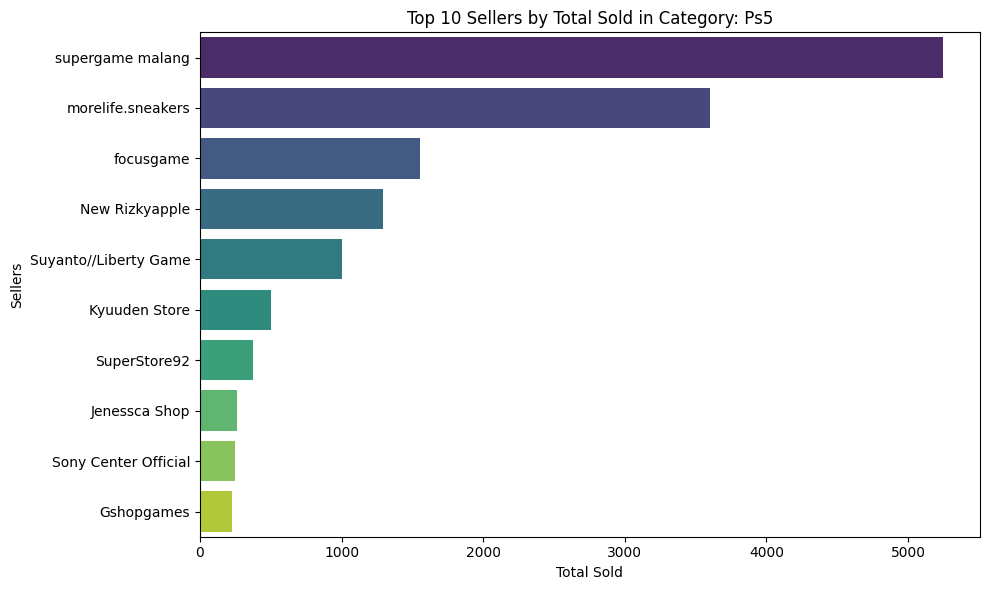

/var/folders/6l/4z64zgys2r1d56qnwjfzs47w0000gn/T/ipykernel_17176/776624029.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_data, y='Seller', x='Total Sold', palette='viridis')


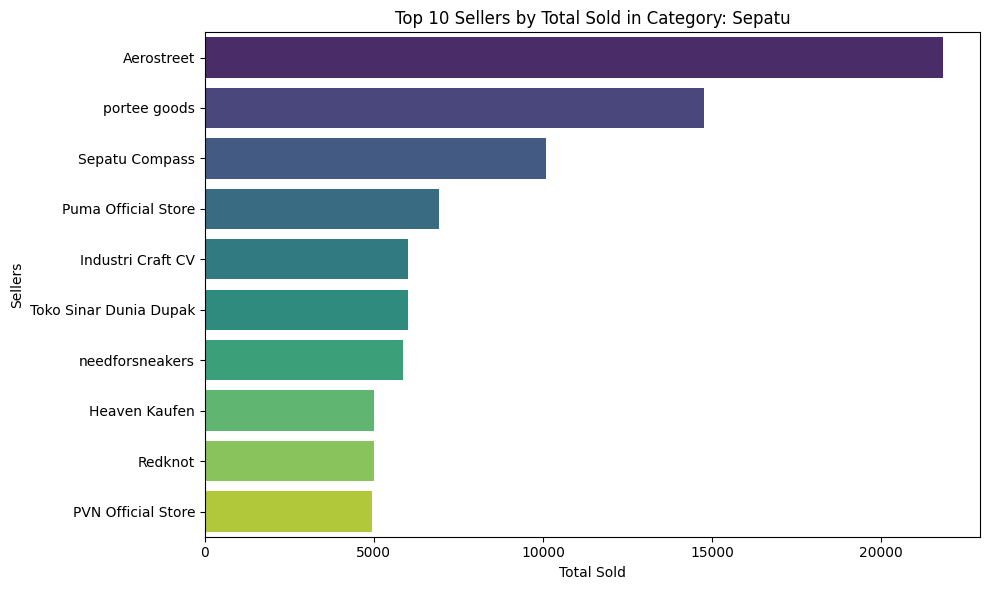

/var/folders/6l/4z64zgys2r1d56qnwjfzs47w0000gn/T/ipykernel_17176/776624029.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_data, y='Seller', x='Total Sold', palette='viridis')


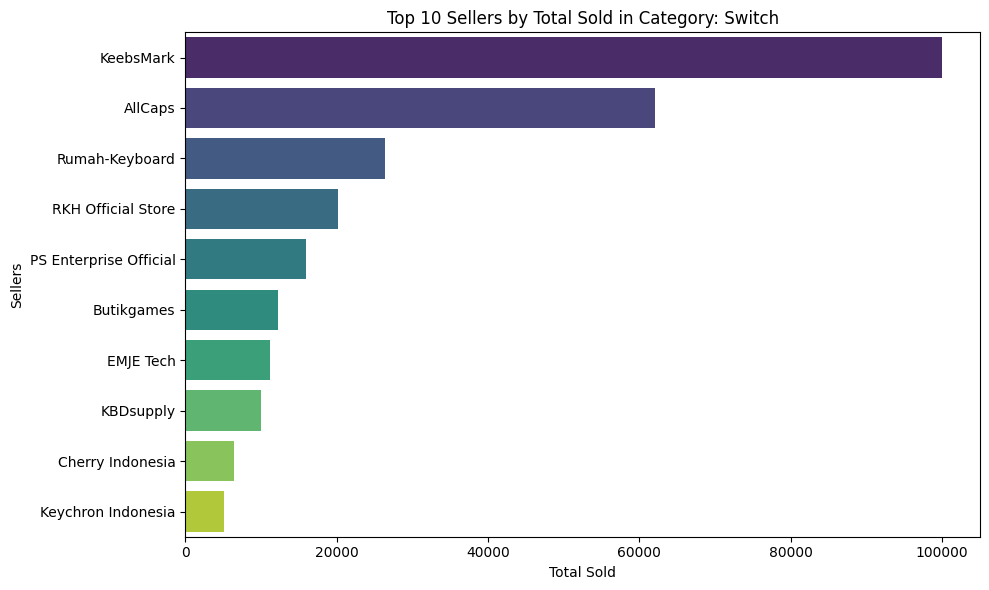

In [47]:

# Function to convert the 'Sold' column to integer
def convert_sold_value(sold_str):
    if pd.isna(sold_str):
        return 0  # Handle NaN values as zero
    # Remove 'terjual' and clean up the string
    sold_str = sold_str.lower().replace(' terjual', '').strip()
    
    # Handle "rb" for thousands and "+" for exceeding counts
    if 'rb' in sold_str:
        sold_value = sold_str.replace('rb', '').strip()
        sold_value = sold_value.rstrip('+')  # Remove any trailing '+'
        return int(sold_value) * 1000  # Handle "1rb", "2rb" as thousands
    elif '+' in sold_str:  # For cases like "100+ terjual"
        sold_value = sold_str.split('+')[0].strip()
        return int(sold_value)  # Take only the part before '+'
    
    return int(sold_str)  # Handle other cases directly

# Convert 'Sold' column to integers
df['Sold'] = df['Sold'].apply(convert_sold_value)

# Filter only for relevant categories (ps5, switch, and sepatu)
filtered_df = df[df['category'].isin(['ps5', 'switch', 'sepatu'])]

# Sum occurrences of sold items in each category by seller
seller_sold_counts = filtered_df.groupby(['category', 'Seller'])['Sold'].sum().reset_index(name='Total Sold')

# Get the top 10 sellers for each category based on total sold
top_sellers = seller_sold_counts.groupby('category').apply(lambda x: x.nlargest(10, 'Total Sold')).reset_index(drop=True)

# Create a separate plot for each category
categories = top_sellers['category'].unique()

for category in categories:
    plt.figure(figsize=(10, 6))
    category_data = top_sellers[top_sellers['category'] == category]
    sns.barplot(data=category_data, y='Seller', x='Total Sold', palette='viridis')

    # Add labels and title
    plt.title(f'Top 10 Sellers by Total Sold in Category: {category.capitalize()}')
    plt.xlabel('Total Sold')
    plt.ylabel('Sellers')
    plt.tight_layout()

    # Show the plot
    plt.show()

In [60]:
# Filter the DataFrame for the category "PS5"
df_ps5 = df[df['category'] == 'ps5']

# Create a DataFrame with unique locations in the PS5 category
unique_locations = df_ps5[['Location']].drop_duplicates()

# Group by location and calculate the mean price for the PS5 category
grouped_by_location = df_ps5.groupby('Location').agg({'Price': 'mean'}).reset_index()

# Display the unique locations and the grouped data
print("Unique Locations in PS5 Category:")
print(unique_locations)

print("\nGrouped by Location for PS5 Category:")
print(grouped_by_location)

# Save the grouped data to a new CSV file
grouped_by_location.to_csv('location_ps5.csv', index=False)  # Replace with your desired output path

Unique Locations in PS5 Category:
                Location
1361  Kab. Bandung Barat
4470   Tangerang Selatan
4623       Jakarta Utara
4675               Depok
4807             Bandung
5095       Jakarta Pusat
6622              Padang
7582              Malang
7673       Jakarta Barat
7945           Tangerang
8173            Magelang
8540               Medan
8632       Jakarta Timur
8635            Surabaya
8636     Jakarta Selatan
8637        Kab. Rembang
8647           Palembang
8677         Kab. Sleman
8695         Kab. Badung
8703              Serang
8704            Denpasar
8705          Kab. Bogor
8715         Banjarmasin
8717          Yogyakarta
8724      Kab. Tangerang
8736         Kab. Bantul
8794           Pontianak
8803        Kab. Bandung
8827               Batam
8836            Makassar
8855       Kab. Sidoarjo
8873           Gorontalo
8895            Semarang
8914           Pekanbaru
8933                Palu
8956       Kab. Kuningan
8973              Bekasi
9243           S

In [62]:
import pandas as pd

# Load the dataset
df_location = pd.read_csv('location_ps5.csv')

# Define the stores and their corresponding target locations
merge_info = {
    'Logitech Official Store': 'Jakarta Utara',
    'Buttonscarves': 'Surabaya',
    'Koodo': 'Kab. Deli Serdang',
    'Mils Technologies Official': 'Jakarta Utara',
    'Miniso Indonesia': 'Bekasi',
    'Promina Official Store': 'Tangerang Selatan',
    'Waroengame': 'Jakarta Utara'
}

# Iterate over the merge_info to calculate mean and update target locations
for store, target in merge_info.items():
    # Get the mean price of the store to be deleted
    mean_price = df_location.loc[df_location['Location'] == store, 'Price'].mean()
    
    # Update the target location with the mean price
    if target in df_location['Location'].values:
        df_location.loc[df_location['Location'] == target, 'Price'] = \
            (df_location.loc[df_location['Location'] == target, 'Price'] + mean_price) / 2
    else:
        # If target location doesn't exist, add a new row
        new_row = pd.DataFrame({'Location': [target], 'Price': [mean_price]})  # Fixed here
        df_location = pd.concat([df_location, new_row], ignore_index=True)

    # Remove the store from the df_location set
    df_location = df_location[df_location['Location'] != store]

# Grouping locations into regions
df_location['Region'] = df_location['Location'].apply(
    lambda x: 'Jabodetabek' if any(city in x for city in ['Jakarta', 'Depok', 'Bogor', 'Tangerang', 'Bekasi']) else 'Other'
)

# Calculate the new mean price based on the region
grouped_by_region = df_location.groupby('Region').agg({'Price': 'mean'}).reset_index()

# Display the updated DataFrame and the grouped mean prices
print("Updated DataFrame with Region:")
print(df_location)

print("\nGrouped by Region with Mean Prices:")
print(grouped_by_region)


Updated DataFrame with Region:
              Location         Price       Region
0              Bandung  6.551735e+06        Other
1          Banjarmasin  5.062150e+06        Other
2                Batam  6.927833e+06        Other
3               Bekasi           NaN  Jabodetabek
4               Cimahi  2.331333e+06        Other
5             Denpasar  8.255667e+06        Other
6                Depok  1.290225e+06  Jabodetabek
7            Gorontalo  8.000000e+06        Other
8        Jakarta Barat  1.586873e+06  Jabodetabek
9        Jakarta Pusat  9.831462e+06  Jabodetabek
10     Jakarta Selatan  7.462829e+06  Jabodetabek
11       Jakarta Timur  4.999397e+06  Jabodetabek
12       Jakarta Utara           NaN  Jabodetabek
13         Kab. Badung  5.708250e+06        Other
14        Kab. Bandung  7.436667e+05        Other
15  Kab. Bandung Barat  2.563500e+05        Other
16         Kab. Bantul  6.250000e+06        Other
17       Kab. Banyumas  1.638000e+06        Other
18          Kab. Bo

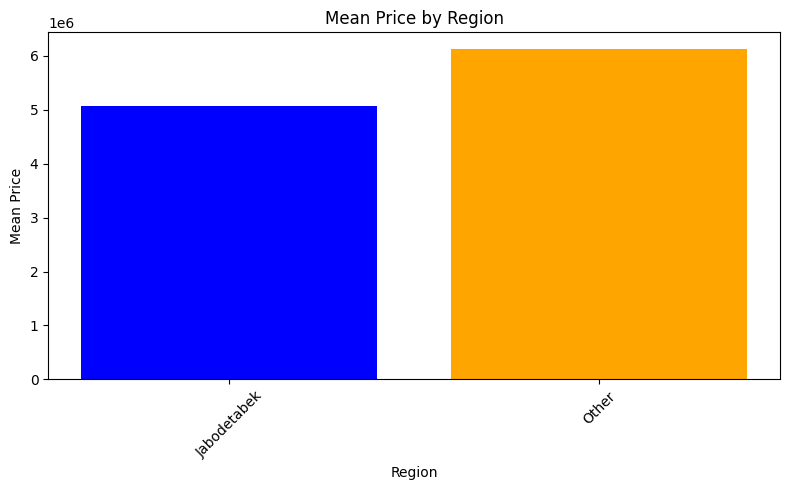

In [63]:
# Plotting the region and price
plt.figure(figsize=(8, 5))
plt.bar(grouped_by_region['Region'], grouped_by_region['Price'], color=['blue', 'orange'])
plt.title('Mean Price by Region')
plt.xlabel('Region')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [69]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Check for NaN values in Price and handle them
if df_location['Price'].isnull().any():
    print("NaN values found in 'Price'. Handling them...")
    # Option 1: Drop rows with NaN prices
    # df_location = df_location.dropna(subset=['Price'])

    # Option 2: Fill NaN values with the mean price
    mean_price = df_location['Price'].mean()
    df_location['Price'].fillna(mean_price, inplace=True)

# Prepare the data for modeling
X = pd.get_dummies(df_location[['Location']], drop_first=True)  # One-hot encoding
y = df_location['Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



NaN values found in 'Price'. Handling them...


In [70]:
# 1. Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg_pred = lin_reg.predict(X_test)
lin_reg_mse = mean_squared_error(y_test, lin_reg_pred)
lin_reg_r2 = r2_score(y_test, lin_reg_pred)

print("Linear Regression MSE:", lin_reg_mse)
print("Linear Regression R^2:", lin_reg_r2)

Linear Regression MSE: 35017223781706.918
Linear Regression R^2: -0.0038480401104632467


In [71]:
# 2. Decision Tree Regressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)
tree_reg_pred = tree_reg.predict(X_test)
tree_reg_mse = mean_squared_error(y_test, tree_reg_pred)
tree_reg_r2 = r2_score(y_test, tree_reg_pred)

print("Decision Tree MSE:", tree_reg_mse)
print("Decision Tree R^2:", tree_reg_r2)

Decision Tree MSE: 35017223781706.926
Decision Tree R^2: -0.0038480401104634687


In [72]:
# 3. Random Forest Regressor (Ensemble Learning)
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
rf_reg_pred = rf_reg.predict(X_test)
rf_reg_mse = mean_squared_error(y_test, rf_reg_pred)
rf_reg_r2 = r2_score(y_test, rf_reg_pred)

print("Random Forest MSE:", rf_reg_mse)
print("Random Forest R^2:", rf_reg_r2)


Random Forest MSE: 35990902232585.55
Random Forest R^2: -0.031760738464434723


In [74]:
# 4. K-Nearest Neighbors Regressor
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)
knn_reg_pred = knn_reg.predict(X_test)
knn_reg_mse = mean_squared_error(y_test, knn_reg_pred)
knn_reg_r2 = r2_score(y_test, knn_reg_pred)

print("KNN Regressor MSE:", knn_reg_mse)
print("KNN Regressor R^2:", knn_reg_r2)


KNN Regressor MSE: 38690052080412.7
KNN Regressor R^2: -0.1091379829198107


In [75]:
# 5. Support Vector Regressor
svr_reg = SVR()
svr_reg.fit(X_train, y_train)
svr_reg_pred = svr_reg.predict(X_test)
svr_reg_mse = mean_squared_error(y_test, svr_reg_pred)
svr_reg_r2 = r2_score(y_test, svr_reg_pred)

print("SVR MSE:", svr_reg_mse)
print("SVR R^2:", svr_reg_r2)

SVR MSE: 35862544589664.65
SVR R^2: -0.028081075876601247
